In [253]:
#! nvidia-smi

In [254]:
#conda install pytorch torchvision -c pytorch

In [255]:
import os
def EXIT_NOTEBOOK(): os._exit(00)
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import torch 
from torch import nn
import torch.nn.functional as func
import seaborn as sns
import matplotlib.ticker
import itertools

# # ps
# import pysindy as ps

# sns.set_theme()
# torch.set_default_dtype(torch.float32)
plt.rcParams['text.usetex'] = True

In [257]:
dim = 6
torch.set_default_dtype(torch.float64)

# Dataset for X

In [258]:
from BeadModel import Simulate
from SimulationParameters import *

X = Simulation(*Simulate(numSims)).positions[:,:,:,0].reshape(-1,nt+1).T
# # Z = X.view

# print(X.shape)
print(X)

[[-8.39636597e-03  1.01099650e-02  9.91270488e-03 -1.25714042e-03
  -1.03790511e-02 -1.93873592e-02]
 [-1.17121197e-02  2.36858662e-02 -3.93688821e-03  2.68598001e-02
   3.70468726e-03 -9.25527331e-03]
 [-5.31925589e-05  4.51809438e-02  5.19950064e-03  5.02629790e-02
   4.30098890e-02 -6.17712801e-03]
 [ 6.88650790e-03  4.58406693e-02  1.70529539e-02  6.68114868e-02
   4.69094841e-02 -4.33511266e-02]
 [ 8.24981080e-03  4.36921179e-02  1.40783186e-02  5.74821281e-02
   4.30966481e-02 -5.26500280e-02]
 [ 8.57348430e-03  5.32676131e-02  1.85777838e-02  7.42281322e-02
   5.47227818e-02 -5.31157740e-02]
 [ 2.55792605e-03  5.04205328e-02 -1.44798249e-03  9.02314415e-02
   6.83192631e-02 -6.44622941e-02]
 [ 8.70444970e-03  6.36443470e-02 -2.88011501e-02  9.66763118e-02
   8.18017453e-02 -7.65496435e-02]
 [-7.13627647e-03  6.44940952e-02 -6.92789704e-02  1.34856420e-01
   8.41094402e-02 -7.60221355e-02]
 [-2.15232799e-02  9.29863088e-02 -6.55843048e-02  1.58221709e-01
   9.84605701e-02 -1.0138

In [259]:
# W = torch.tensor(pd.read_csv('alpha1_W.txt', header = None).values).T
# print(W)
# print(W.shape)
# print()
# X = torch.tensor(pd.read_csv('alpha1_path.txt', header = None).values).T
# X.requires_grad_()
# print(X)
# print(X.shape)

# Set the NN model and Solver with training process

In [260]:
def relu2(X): return func.relu(X)**2
def tanh(X): return func.tanh(X)
class FCNN(nn.Module):
    def __init__(self,input_dim=6,output_dim=6,num_hidden=2,hidden_dim=10,act=func.tanh,transform=None):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layers  = nn.ModuleList([nn.Linear(input_dim,hidden_dim)])
        for _ in range(num_hidden-1): self.layers.append(nn.Linear(hidden_dim,hidden_dim))
        self.act     = act
        self.out     = nn.Linear(hidden_dim,output_dim)
        self.transform = transform
    def forward(self,X):
        if self.transform is not None: X = self.transform(X)
        for layer in self.layers: X = self.act(layer(X))
        Y = self.out(X)
        return Y
class Model(nn.Module):
    def __init__(self,dim,model_U,unit_len=int(5e3)):
        super().__init__()
        self.dim      = dim
        self.model_U  = model_U
        self.unit_len = unit_len
        self.mu       = nn.Parameter(torch.tensor([0.]*dim),requires_grad=False) 
        self.sigma    = nn.Parameter(torch.tensor([1.]*dim),requires_grad=False)
        #above two lines should work, but if something doesn't work, check here! Does current self.mu and self.sigma code work if dim>1. Should return a vector since what we're trying to do is calculate mu
        #and sigma separately for each imnputted feature. mu is parameter[0] for each row.
        self.coef_U   = nn.Parameter(torch.tensor([1.]*dim),requires_grad=False)
        #self.mu       = nn.Parameter(torch.tensor([0.]*dim).cuda(),requires_grad=False)
        #self.sigma    = nn.Parameter(torch.tensor([1.]*dim).cuda(),requires_grad=False)
        #self.coef_U   = nn.Parameter(torch.tensor(1.).cuda(),requires_grad=False)
    def get_U_harmonic(self,X): return torch.sum(X**2,axis=-1)
        
    
    def get_U_dU(self,X):
        # normalize and ensure x is a tensor
        if not torch.is_tensor(X): X = torch.tensor(X, requires_grad=True)
        U = self.model_U(X).view(-1)
        dU = torch.autograd.grad(U, X, torch.ones_like(U), create_graph=True)[0]
        # dU = dU.T
        return U,dU

    
    def get_U_np(self,X): 
        U,_ = self.get_U_dU(X);
        return U.cpu().data.numpy()
    
    # def get_U_numerical_integration(self,X, dX):
    #     outputU = []
    #     _,dU = self.get_U_dU(X)
    #     # Assume dU has more than two features. for each timestep we'll numerically integrate. current shape is 6x10
    #     #Trapezoid rule for numerical integration by each timestep
    #     for t in range(dU.shape[1]):
    #         currentSum = 0
    #         currentDU = dU[:,t]
    #         for i in range(len(currentDU)):
    #             if i == len(currentDU)-1 or i == 0:
    #                 currentSum += currentDU[i] / 2
    #             else:
    #                 currentSum += currentDU[i]
    #         currentSum *= dX
    #         outputU.append(currentSum + sum(outputU))
    #     U = torch.tensor(outputU)
    #     return U
    
    def get_U_line_integration(self, X, nt):
        _,dU = self.get_U_dU(X)
        print(f"dU: {dU}")
        midpoints = [ (X[t+1,:] - X[t-1, :]) / 2 for t in range(1,9)]
        midpoints = [midpoints[0]] + midpoints + [midpoints[-1]]
        midpoints = torch.abs(torch.tensor(midpoints))
        print(f"midpoints: {midpoints}")

        U = []
        for t in range(dU.shape[0] - 1):
            U.append(torch.sum(midpoints[t, :] * dU[t, :]))
        U = torch.stack(U)
        U = torch.cat((torch.tensor([0]), ((U[1:] + U[:nt - 1]) / 2)), dim=0)
        U = torch.tensor(list(itertools.accumulate(U)))
        return U
    

    
class Solver():
    def __init__(self,model):
        self.model=model
    def train_model(self,data_train,data_test,get_loss,optimizer,
                    n_steps,batch_size,scheduler=None,n_show_loss=100,error_model=None,use_tqdm=True):
        if use_tqdm: step_range = tqdm(range(n_steps))
        else: step_range = range(n_steps)
        loss_step = []
        for i_step in step_range:
            if i_step%n_show_loss==0:
                loss_train,loss_test = get_loss(self.model,data_train)[:-1],\
                                       get_loss(self.model,data_test)[:-1]
                
                def show_num(x): 
                    if abs(x)<100 and abs(x)>.01: return '%0.5f'%x
                    else: return '%0.2e'%x
                item1 = '%2dk'%np.int_(i_step/1000)
                item2 = 'Loss: '+' '.join([show_num(k) for k in loss_train])
                item3 = ' '.join([show_num(k) for k in loss_test])
                item4 = ''
                if error_model is not None: item4 = 'E(QP): %0.4f' % (error_model(self.model))
                print(', '.join([item1,item2,item3,item4]))
                loss_step = loss_step + [i_step] + [k.cpu().data.numpy() for k in loss_train]\
                                                 + [k.cpu().data.numpy() for k in loss_train]
            data_batch = data_train[random.sample(range(len(data_train)),
                                                  min(batch_size,len(data_train)))]
#             print(i_step,data_batch.shape)
            loss = get_loss(self.model,data_batch)[-1]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler is not None: scheduler.step()
        if error_model is not None: 
            print("Error: %0.5f" % (error_model(self.model)))
        return loss_step

In [261]:
model_U = FCNN(input_dim=dim,output_dim=1,num_hidden=3,hidden_dim=10,act=tanh)#.cuda()
model   = Model(dim,model_U=model_U)#.cuda();
SOL     = Solver(model)

In [262]:
# print(model.get_U_dU(X))

In [263]:
# print(model.mu.shape)
# print(model.mu)

In [264]:
# def plot_model(model,cmap='terrain',max_V = 10):
    
#     xx     = np.linspace(0,2,1000).reshape(-1,1)
#     U_NN   = model.get_U_np(xx)
#     U_NN_min = U_NN.min()
#     U_NN  = U_NN-U_NN_min

#     fig, ax    = plt.subplots(1,1,figsize=(5,3),dpi=200,constrained_layout=True)
#     c      = ax.plot(xx[:,0],U_NN,'-',lw=1.5,)

#     ax.tick_params(axis="both", labelsize=10)
#     plt.show()

# Set the loss function and Train the model for differen a_k(x)

In [265]:
from Loss import getResidue, getAllResidues

# def plot_model(model,cmap='terrain',max_V = 10):
    
#     # xx     = np.linspace(0,2,1000).reshape(-1,1)
#     # U_NN   = model.get_U_np(xx)
#     U_NN   = model.get_U_np(X)
#     U_NN_min = U_NN.min()
#     U_NN  = U_NN-U_NN_min
#     fig, ax    = plt.subplots(1,1,figsize=(5,3),dpi=200,constrained_layout=True)
#     c      = ax.plot(X[:,0],U_NN,'-',lw=1.5,)

    # ax.tick_params(axis="both", labelsize=10)
    # plt.show()

def plot_model(model,cmap='terrain',max_V = 10,):
    xx     = np.linspace(0,2,nt).reshape(-1,1)
    U_NN = model.get_U_line_integration(X, nt)
    print()
    print(f"initial U: {U_NN}")
    U_NN = U_NN[:nt]
    U_NN_min = U_NN.min()
    U_NN  = U_NN-U_NN_min
    print()
    print(f"after some changes U: {U_NN}")
    U_NN_np = U_NN.detach().numpy()
    fig, ax    = plt.subplots(1,1,figsize=(5,3),dpi=200,constrained_layout=True)
    c        = ax.plot(xx[:,0],U_NN_np,'-',lw=1.5)

def get_loss(model,data):
    X = data
    X = torch.tensor(X).clone().detach().requires_grad_(True)
    _,dU = model.get_U_dU(X)
    # Note we are feeding in a gradient below:
    # gradients = torch.tensor(pd.read_csv('alpha1_dW.txt', header = None).values)

    loss = getAllResidues(X, dU)
    return loss#,loss


# plot_model(model)
# is get loss working? ignore the print outs that come from it
get_loss(model,X)

[tensor(0.0007, grad_fn=<PowBackward0>),
 tensor(0.0008, grad_fn=<PowBackward0>),
 tensor(0.0010, grad_fn=<PowBackward0>),
 tensor(0.0010, grad_fn=<PowBackward0>),
 tensor(0.0009, grad_fn=<PowBackward0>),
 tensor(0.0010, grad_fn=<PowBackward0>),
 tensor(0.0011, grad_fn=<PowBackward0>),
 tensor(0.0010, grad_fn=<PowBackward0>),
 tensor(0.0012, grad_fn=<PowBackward0>),
 tensor(0.0011, grad_fn=<PowBackward0>),
 tensor(0.0011, grad_fn=<PowBackward0>)]

  0%|          | 0/50001 [00:00<?, ?it/s]

 0k, Loss: 9.36e-04 1.09e-03 1.46e-03 1.34e-03 1.32e-03 1.44e-03 1.68e-03 1.92e-03 2.30e-03 2.58e-03, 9.36e-04 1.09e-03 1.46e-03 1.34e-03 1.32e-03 1.44e-03 1.68e-03 1.92e-03 2.30e-03 2.58e-03, 
 1k, Loss: 3.64e-08 4.39e-08 1.55e-07 1.17e-08 4.63e-08 2.35e-08 7.95e-09 4.52e-08 4.96e-09 1.78e-08, 3.64e-08 4.39e-08 1.55e-07 1.17e-08 4.63e-08 2.35e-08 7.95e-09 4.52e-08 4.96e-09 1.78e-08, 
 2k, Loss: 4.21e-09 2.62e-09 8.25e-09 4.43e-09 1.89e-08 7.84e-09 2.28e-09 2.58e-08 4.51e-10 5.29e-09, 4.21e-09 2.62e-09 8.25e-09 4.43e-09 1.89e-08 7.84e-09 2.28e-09 2.58e-08 4.51e-10 5.29e-09, 
 3k, Loss: 3.56e-09 7.80e-10 1.67e-09 1.12e-10 7.11e-10 1.55e-10 1.10e-09 5.90e-10 6.27e-09 1.80e-08, 3.56e-09 7.80e-10 1.67e-09 1.12e-10 7.11e-10 1.55e-10 1.10e-09 5.90e-10 6.27e-09 1.80e-08, 
 4k, Loss: 4.40e-09 3.62e-10 3.70e-10 1.10e-09 4.44e-11 1.82e-09 1.80e-09 1.73e-10 4.71e-09 1.57e-08, 4.40e-09 3.62e-10 3.70e-10 1.10e-09 4.44e-11 1.82e-09 1.80e-09 1.73e-10 4.71e-09 1.57e-08, 
 5k, Loss: 5.01e-09 3.27e-11 1

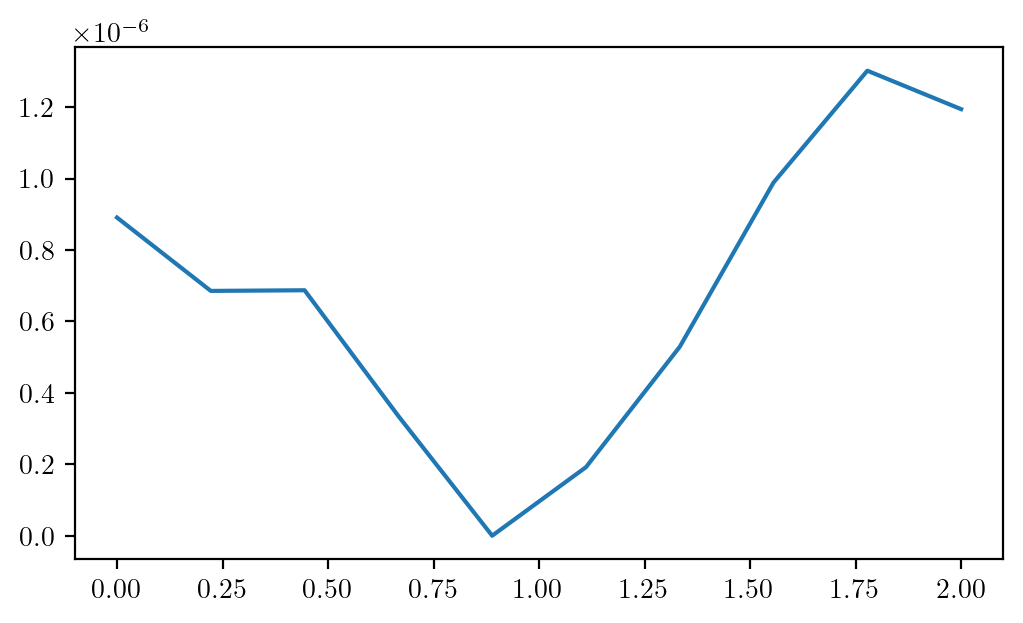

In [266]:
#for choose_id in [1,2,3]:
model_U = FCNN(input_dim=dim,output_dim=1,num_hidden=3,hidden_dim=10,act=tanh)#.cuda()
model   = Model(dim,model_U=model_U)#.cuda();
SOL     = Solver(model)

# print(model.mu,model.sigma,model.coef_U)
    #optimizer = torch.optim.Adam(model.parameters(), lr=torch.tensor(0.001).cuda())
optimizer = torch.optim.Adam(model.parameters(), lr=torch.tensor(0.001))
scheduler = None
_loss_step = SOL.train_model(data_train=X,data_test=X,
                             get_loss=get_loss,optimizer=optimizer,scheduler=scheduler,
                             n_steps=int(5e4+1),batch_size=500,n_show_loss=1000,use_tqdm=True)

# 5e4+1
torch.cuda.empty_cache()
plot_model(model)
# torch.save(model.state_dict(), "savee/model_"+str(choose_id))
#torch.save(model.state_dict(),"savee/model_anaconda3")

In [267]:
# def get_U_line_integration(self, X, dU, dX):
def TEST_get_U_line_integration():
    dU = torch.tensor(pd.read_csv('alpha1_dW.txt', header = None).values).T
    X = torch.tensor(pd.read_csv('alpha1_path.txt', header = None).values).T
    nt = 10
    
    midpoints = [ (X[t+1,:] - X[t-1, :]) / 2 for t in range(1,9)]
    midpoints = [midpoints[0]] + midpoints + [midpoints[-1]]
    midpoints = torch.stack(midpoints)

    U = []
    for t in range(dU.shape[0]):
        U.append(torch.sum(midpoints[t, :] * dU[t, :]))
    U = torch.stack(U)
    U = torch.cat((torch.tensor([0]), ((U[1:] + U[:nt - 1]) / 2)), dim=0)
    U = torch.tensor(list(itertools.accumulate(U)))
    return U


In [268]:
# def plot_side_by_side_bar_chart(array1, array2):    
#     """
#     Plots a bar chart for two 10-length datasets (PyTorch tensors, NumPy arrays, or lists),
#     where bars are placed side by side, and exact values are displayed above each bar.

#     Parameters:
#         array1 (torch.Tensor, np.array, or list): First dataset of length 10.
#         array2 (torch.Tensor, np.array, or list): Second dataset of length 10.
#     """
#     # Convert PyTorch tensors to NumPy if necessary
#     if isinstance(array1, torch.Tensor):
#         array1 = array1.numpy()
#     if isinstance(array2, torch.Tensor):
#         array2 = array2.numpy().flatten()

#     print(array1)
#     print(array2)
#     # # Ensure inputs are NumPy arrays
#     # array1 = np.array(array1)
#     # array2 = np.array(array2)

#     # X-axis positions
#     x = np.arange(len(array1))

#     # Bar width to ensure bars are next to each other
#     bar_width = 0.4

#     # Create the bar plot
#     fig, ax = plt.subplots(figsize=(20, 10))
#     bars1 = ax.bar(x - bar_width/2, array1, width=bar_width, label="Array 1")
#     bars2 = ax.bar(x + bar_width/2, array2, width=bar_width, label="Array 2")

#     # Add data labels above bars
#     for bars in [bars1, bars2]:
#         for bar in bars:
#             height = bar.get_height()
#             ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.6f}', 
#                     ha='center', va='bottom', fontsize=10)

#     # Labels and legend
#     ax.set_xlabel("Index")
#     ax.set_ylabel("Value")
#     ax.set_title("Side-by-Side Bar Chart with Data Labels")
#     ax.set_xticks(x)  # Ensure correct x-axis labels
#     ax.legend()

#     # Show the plot
#     plt.show()

# plot_side_by_side_bar_chart(TEST_get_U_line_integration(), torch.tensor(pd.read_csv('alpha1_W.txt', header = None).values))

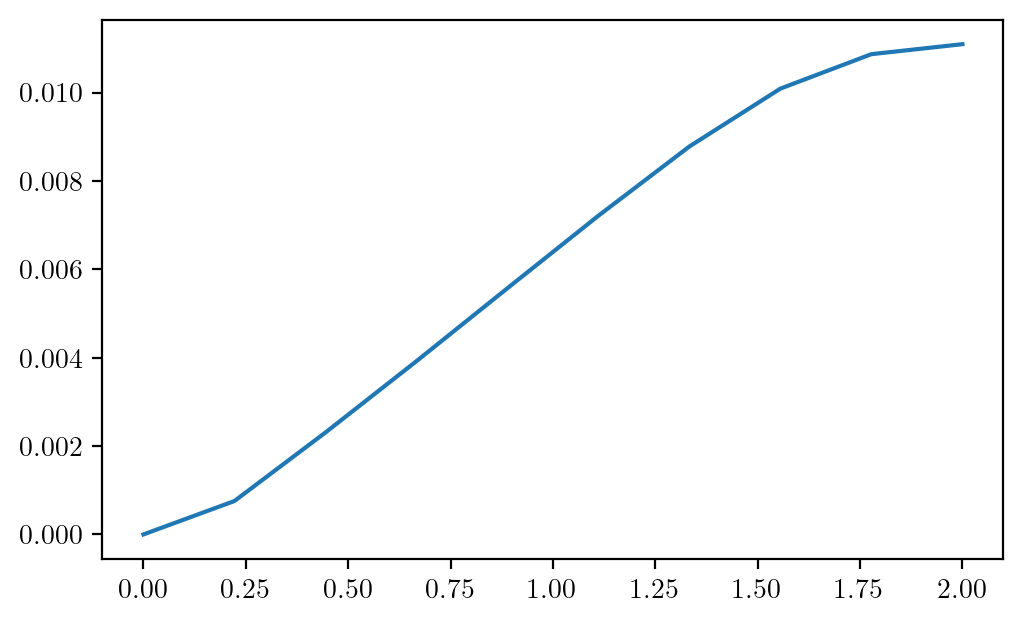

In [269]:
def plot_compare(cmap='terrain',max_V = 10,):
    nt=10
    xx     = np.linspace(0,2,nt).reshape(-1,1)
    W_compare = torch.tensor(pd.read_csv('alpha1_W.txt', header = None).values).T
    fig, ax    = plt.subplots(1,1,figsize=(5,3),dpi=200,constrained_layout=True)
    c        = ax.plot(xx[:,0],W_compare,'-',lw=1.5)
plot_compare()

# Visualizing the results for different a_k(x)

In [270]:
def plot_models(models):
    
    xx       = np.linspace(0,2,1000).reshape(-1,1)
    fig, ax  = plt.subplots(1,1,figsize=(4,3),dpi=200,constrained_layout=True)
    
    for k,model_name in enumerate(models):
        model.load_state_dict(torch.load(model_name))
        U_NN     = model.get_U_np(xx)
        U_NN_min = U_NN.min()
        U_NN     = U_NN-U_NN_min
        c        = ax.plot(xx[:,0],U_NN,'-',lw=1.5,label="$a_{%d}(x)$"%(k+1))
    ax.legend(fontsize=10)
    ax.set_xlabel('$x$',fontsize=10)
    ax.set_ylabel('$U(x)$',fontsize=10)
    ax.set_xlim([0,2])
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1,1.2])
    ax.set_xticks([0,.5,1.,1.5,2])
    ax.yaxis.grid(linestyle='--')
    ax.tick_params(axis="both", labelsize=10)
    plt.show()
# plot_models(["savee/model_anaconda3"])
#plot_models(["savee/model_a1_update", "savee/model_a2_update", "savee/model_a3_update", "savee/model_a4", "savee/model_a5_update"])

In [271]:
# fig, ax  = plt.subplots(1,1,figsize=(4,3),dpi=200,constrained_layout=True)
# xx       = np.linspace(0,2,1000).reshape(-1,1)
# U_NN     = model.get_U_np(xx)
# U_NN_min = U_NN.min()
# U_NN     = U_NN-U_NN_min
# c        = ax.plot(xx[:,0],U_NN,'-',lw=1.5)
# ax.legend(fontsize=10)
# ax.set_xlabel('$x$',fontsize=10)
# ax.set_ylabel('$U(x)$',fontsize=10)
# ax.set_xlim([0,2])
# ax.set_yticks([0,0.2,0.4,0.6,0.8,1,1.2])
# ax.set_xticks([0,.5,1.,1.5,2])
# ax.yaxis.grid(linestyle='--')
# ax.tick_params(axis="both", labelsize=10)
# plt.show()

#torch.save(model.state_dict(), "savee/model_99")
#model.state_dict()

# U_NN

# model

# torch.load("/Users/annacoletti/Desktop/savee/model_a3_update.mat")

# import scipy.io as scio
# from scipy.io import savemat
# scio.savemat('W2_learned_DL', U_NN)